## Inference for data with autoregressive-moving-average (ARMA) errors

This example shows you how to perform Bayesian inference on a time series, using [Differential Evolution MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/differential_evolution_mcmc.html).

It follows on from the [first sampling example](../../sampling/first-example.ipynb).

## Generating data with AR1 errors

Here the observed data follows,

$$y(t) \sim \mathcal{N}\left(f(t; \theta), \epsilon(t)\right),$$

where, $$\epsilon(t) = \rho \epsilon(t-1) + \nu(t),$$ and $\nu(t) \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma \sqrt{1 - \rho^2})$. The noise process standard deviation is such that the marginal distribution of $\epsilon$ is,

$$\epsilon\sim\mathcal{N}(0, \sigma).$$

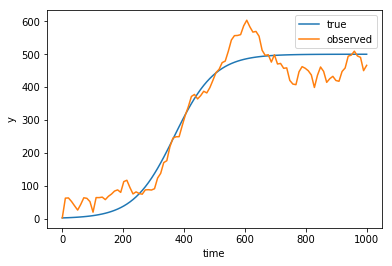

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 40
rho = 0.9
errors = pints.noise.ar1(rho, noise, len(org_values))
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

## Fit model with independent errors to AR1 data

This model is not a correct representation of the noise and so the posteriors will understate true uncertainty.

Running...
Done!
R-hat:
[1.0004583147082631, 1.0001322596875799, 1.0006377880279933]


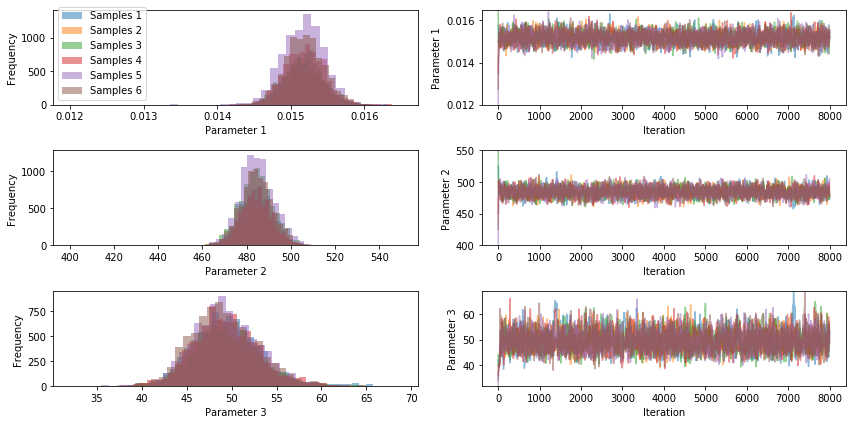

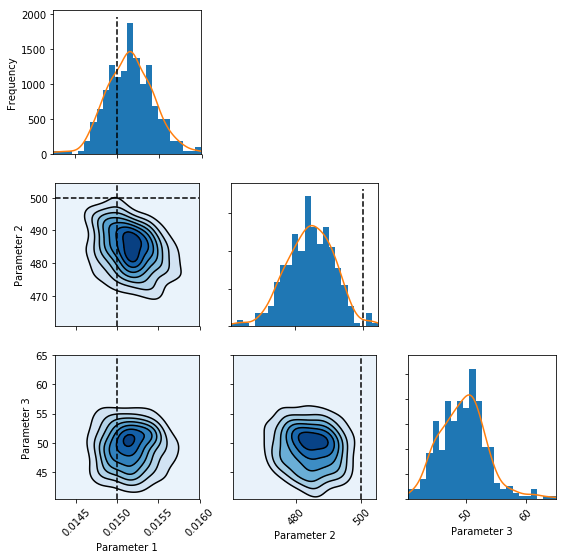

In [2]:
# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters + [noise])
xs = [
    real_parameters1 * 1.05,
    real_parameters1 * 1,
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 0.8,
    real_parameters1 * 0.85,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 6, xs, method=pints.DifferentialEvolutionMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Disable logging
mcmc.set_log_to_screen(False)

# Set number of iterations between which gamma=1 (for a single iteration)
mcmc.sampler().set_gamma_switch_rate(2000)

# Set to uniform error process rather than Gaussian
mcmc.sampler().set_gaussian_error(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 5000:, :]

# Apply thinning
chains = chains[:, ::10, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters1)

# Show graphs
plt.show()

## Fit model with AR1 errors

Posterior uncertainties here are more realistic.

Running...
Done!
R-hat:
[1.0033027335807947, 1.0020863365747912, 1.0028117203911417, 1.006539054627642]


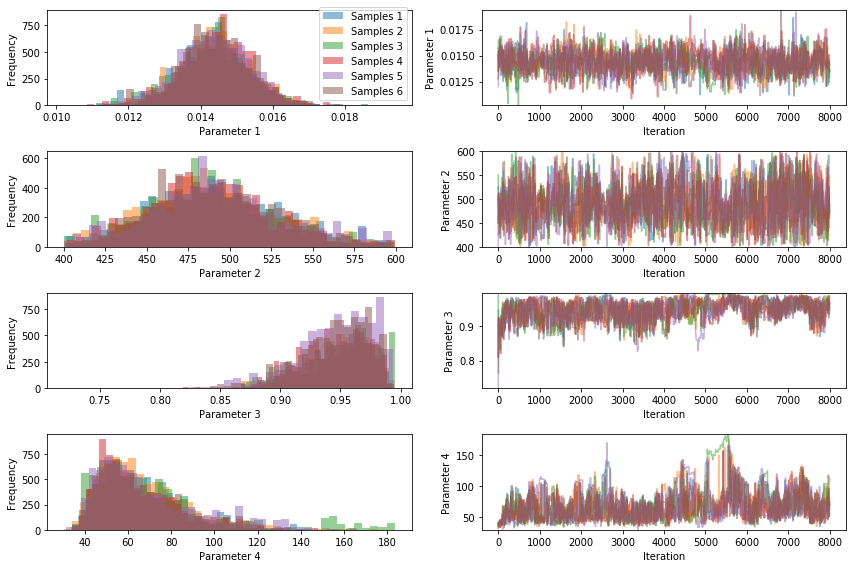

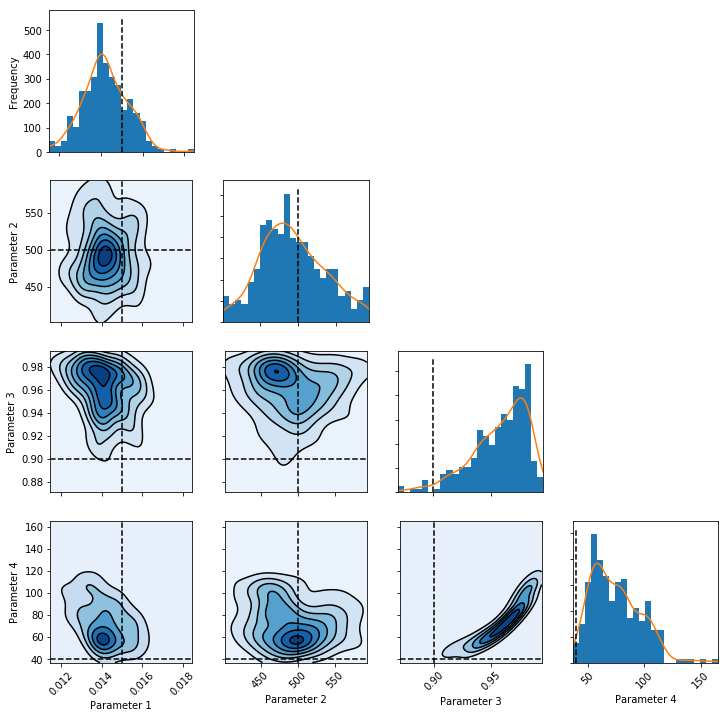

In [3]:
# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.AR1LogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, noise * 0.1],
    [0.02, 600, 1, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters + [rho, noise])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 0.8,
    real_parameters * 0.85,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 6, xs, method=pints.DifferentialEvolutionMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Disable logging
mcmc.set_log_to_screen(False)

# Set number of iterations between which gamma=1 (for a single iteration)
mcmc.sampler().set_gamma_switch_rate(2000)

# Set to uniform error process rather than normal
mcmc.sampler().set_gaussian_error(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 5000:, :]

# Apply thinning
chains = chains[:, ::10, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters)

# Show graphs
plt.show()

## Generate model with ARMA errors

Here the observed data follows,

$$y(t) \sim \mathcal{N}\left(f(t; \theta), \epsilon(t)\right),$$

where, $$\epsilon(t) = \rho \epsilon(t-1) + \nu(t) + \phi \nu(t-1),$$ and $\nu(t) \overset{i.i.d.}{\sim} \mathcal{N}(0, \sigma \sqrt{(1 - \rho^2) / (1 + 2 \rho \phi + \phi^2))}$.  The noise process standard deviation is such that the marginal distribution of $\epsilon$ is,

$$\epsilon\sim\mathcal{N}(0, \sigma).$$

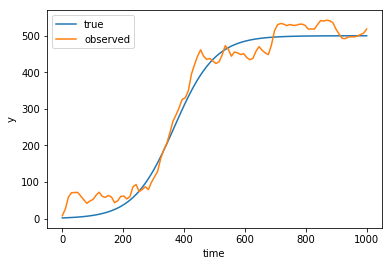

In [4]:
# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 40
rho = 0.9
phi = 0.95
errors = pints.noise.arma11(rho, phi, noise, len(org_values))
values = org_values + errors

# Show the noisy data
plt.figure()
plt.plot(times, org_values)
plt.plot(times, values)
plt.xlabel('time')
plt.ylabel('y')
plt.legend(['true', 'observed'])
plt.show()

## Fit model with independent errors to ARMA(1,1) data

The posterior uncertainties here are even more understated relative to their value under the true data generating process.

Running...
Done!
R-hat:
[1.0002996493568621, 1.0006235565074886, 1.0011048784145706]


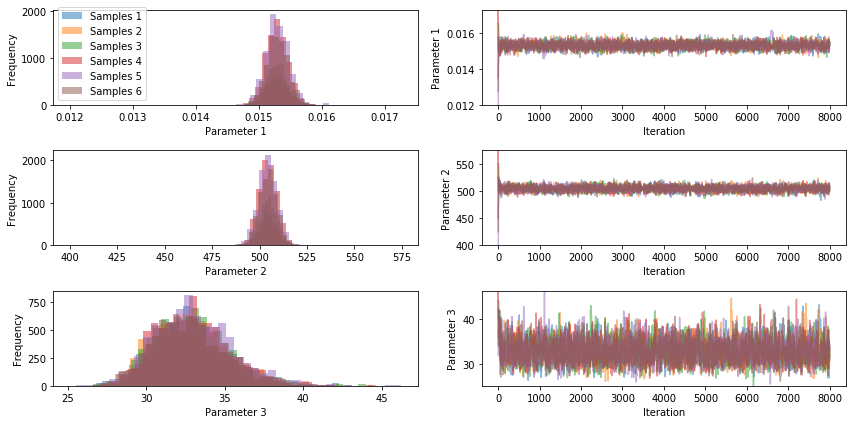

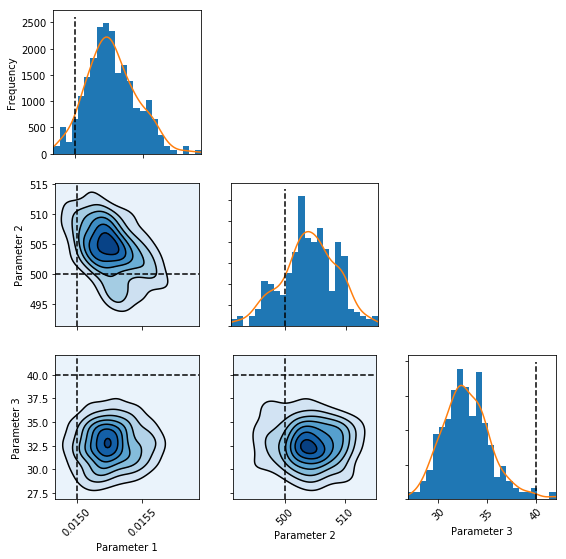

In [5]:
# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(real_parameters + [noise])
xs = [
    real_parameters1 * 1.05,
    real_parameters1 * 1,
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 0.8,
    real_parameters1 * 0.85,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 6, xs, method=pints.DifferentialEvolutionMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Disable logging
mcmc.set_log_to_screen(False)

# Set number of iterations between which gamma=1 (for a single iteration)
mcmc.sampler().set_gamma_switch_rate(2000)

# Set to uniform error process rather than normal
mcmc.sampler().set_gaussian_error(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 5000:, :]

# Apply thinning
chains = chains[:, ::10, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters1)

# Show graphs
plt.show()

## Fit model with ARMA(1, 1) errors

The posterior uncertainties are now considerably greater.

No handlers could be found for logger "pints._mcmc._differential_evolution"


Running...
Done!
R-hat:
[1.0026510050640614, 1.0044506564101208, 1.0059157734340352, 1.0047611480511531, 1.0107849922494241]


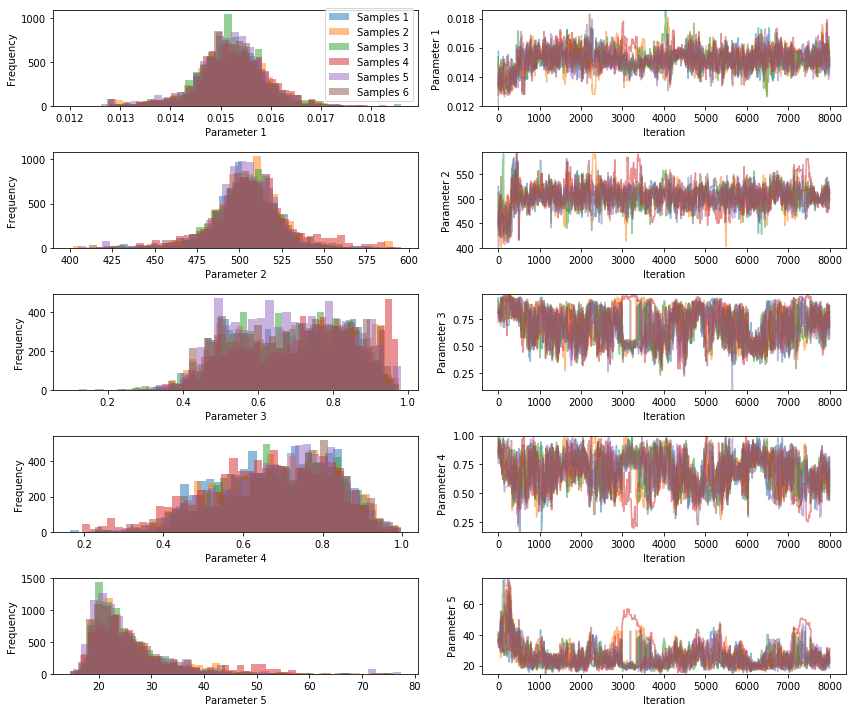

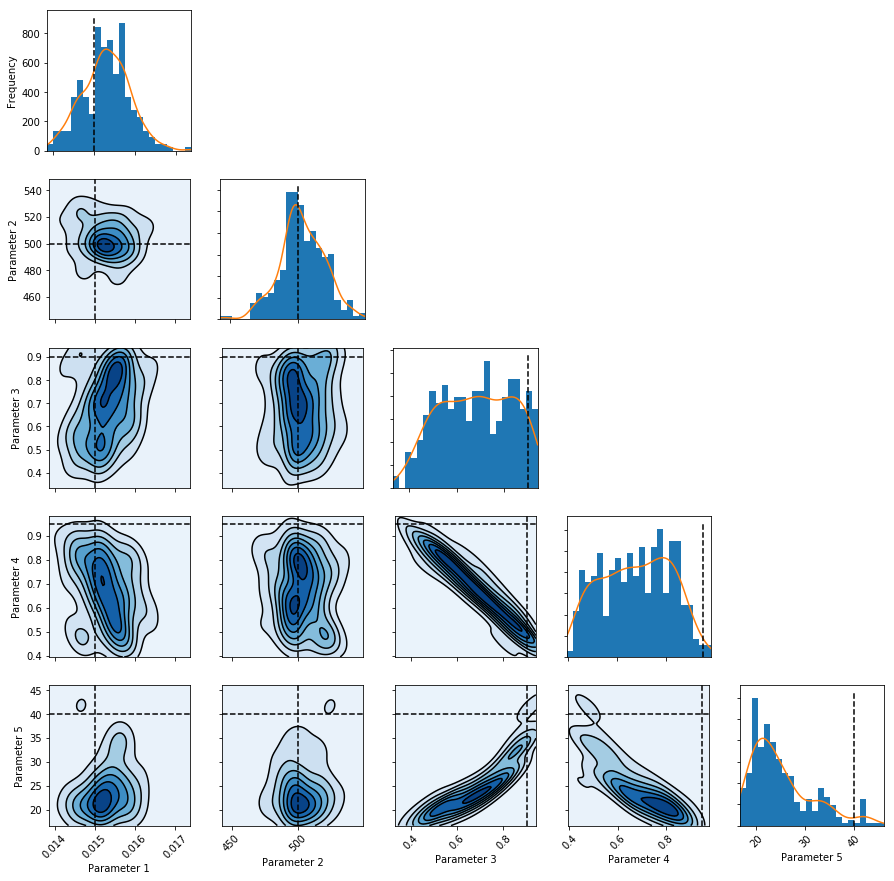

In [6]:
# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.ARMA11LogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, 0, noise * 0.1],
    [0.02, 600, 1, 1, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters = np.array(real_parameters + [rho, phi, noise])
xs = [
    real_parameters * 1.05,
    real_parameters * 1,
    real_parameters * 1.025,
    real_parameters * 0.9,
    real_parameters * 0.8,
    real_parameters * 0.85,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 6, xs, method=pints.DifferentialEvolutionMCMC)

# Add stopping criterion
mcmc.set_max_iterations(8000)

# Disable logging
mcmc.set_log_to_screen(False)

# Set number of iterations between which gamma=1 (for a single iteration)
mcmc.sampler().set_gamma_switch_rate(2000)

# Set to uniform error process rather than normal
mcmc.sampler().set_gaussian_error(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 5000:, :]

# Apply thinning
chains = chains[:, ::10, :]

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters)

# Show graphs
plt.show()